# 2 - Stereo Vision

John Wu - 260612056

Use a stereo image-pair of your choice from the Middlebury dataset: http: //vision.middlebury.edu/stereo/data/ for the following questions. The dataset provides depth images in .pfm format. A function to read such ﬁle in provided along with this assignment

In [1]:
import sys
import re
from struct import *
import numpy as np
from matplotlib import pyplot as plt
import cv2
import math

## 2.1 - Depth Estimation from Stereo Image

#### Estimate depth using the stereo image pair. Show the results of varying the following parameters: blockSize ∈ [5,10,15], numDisparities ∈ [16,32,48]. You will have a total of 9 depth-maps, each corresponding to one combination of blocksize and numDisparities.

In [8]:
''' Provided function for reading a pfm file '''
def read_pfm(file):
    # Adopted from https://stackoverflow.com/questions/37073108/how-to-read-pfm-files-provided-with-middlebury-dataset?rq=1
    with open(file, "rb") as f:
        # Line 1: PF=>RGB (3 channels), Pf=>Greyscale (1 channel)
        type = f.readline().decode('latin-1')
        if "PF" in type:
            channels = 3
        elif "Pf" in type:
            channels = 1
        else:
            sys.exit(1)
        # Line 2: width height
        line = f.readline().decode('latin-1')
        width, height = re.findall('\d+', line)
        width = int(width)
        height = int(height)

        # Line 3: +ve number means big endian, negative means little endian
        line = f.readline().decode('latin-1')
        BigEndian = True
        if "-" in line:
            BigEndian = False
        # Slurp all binary data
        samples = width * height * channels;
        buffer = f.read(samples * 4)
        # Unpack floats with appropriate endianness
        if BigEndian:
            fmt = ">"
        else:
            fmt = "<"
        fmt = fmt + str(samples) + "f"
        img = unpack(fmt, buffer)
        img = np.flipud(np.array(img).reshape(height, width))
        img[img==np.inf] = 0
    return img

In [9]:
''' Plots list of results in a grid. '''
def plot_figs(results, image_key, max_col=4):
    
    # Each plot can hold up to 8 images.
    num_results = len(results)
    rows_per_set = 8 // max_col 
    fig_per_set = rows_per_set * max_col
    num_sets = math.ceil(num_results / fig_per_set)
    
    for s in range(num_sets):
        # starting index of  set
        start = s * fig_per_set
    
        # compute the number of images and rows in the current set 
        subset_len = min(start+fig_per_set, num_results) - start
        num_rows = math.ceil(subset_len / max_col)
        
        # set subplot map 
        subplot = "{}{}".format(num_rows, max_col)
        plt.figure(figsize=(20, 5 * num_rows))
        for i in range(subset_len):
            plt.subplot(int("{}{}".format(subplot, i+1)))
            plt.title(results[start + i]['title'])
            plt.axis('off')
            plt.imshow(results[start + i][image_key], cmap='gray')
    plt.show()

In [10]:
''' Computes the disparity between two images '''
def compute_disparity(img_left, img_right, num_disparities, block_size):
    stereo = cv2.StereoBM_create(numDisparities=num_disparities, blockSize=block_size)
    disparity = stereo.compute(img_left,img_right)
    return disparity

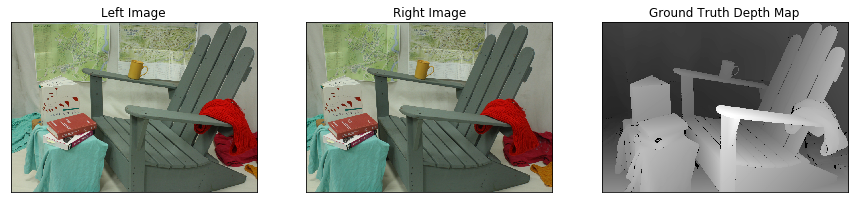

Depth map for each permutation of number of disparities and block size.


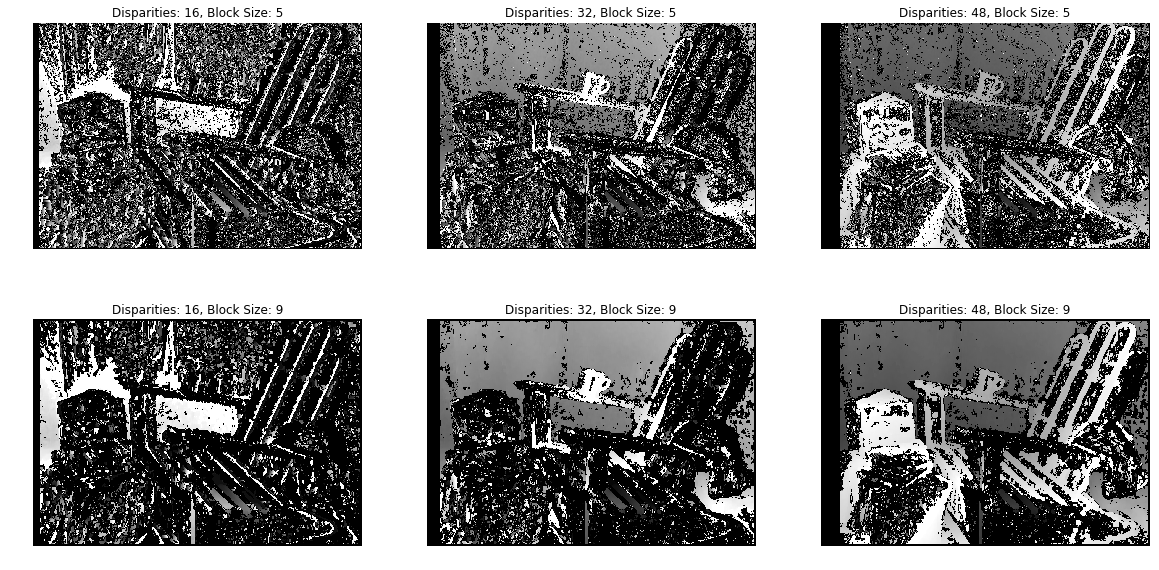

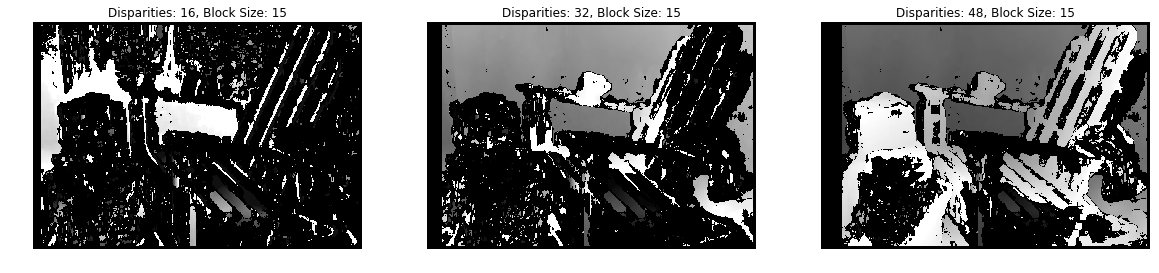

In [11]:
# load left and right images
img_left = cv2.imread('im0.png')
img_right = cv2.imread('im1.png')

# read ground truth image
ground_truth = read_pfm('disp0.pfm')
ground_truth = cv2.resize(ground_truth, None, fx=0.3, fy=0.3)

# resize images for fast processing
img_left = cv2.resize(img_left, None, fx=0.3, fy=0.3)
img_right = cv2.resize(img_right, None, fx=0.3, fy=0.3)

# convert to grayscale
img_left_gray = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
img_right_gray = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

# compute disparity for each permutation
block_sizes, num_disparities, results = [5, 9, 15], [16, 32, 48], []

for b in block_sizes:
    for n in num_disparities:
        result = compute_disparity(img_left_gray, img_right_gray, n, b)
        results.append({
            'depth_map': result,
            'num_disparities': n,
            'block_size': b,
            'title': 'Disparities: ' + str(n) + ', Block Size: ' + str(b)
        })

# display original images
plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB))
plt.title('Left Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB))
plt.title('Right Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(ground_truth, cmap='gray')
plt.title('Ground Truth Depth Map'), plt.xticks([]), plt.yticks([])
plt.show()

print('Depth map for each permutation of number of disparities and block size.')

# plot depth maps
plot_figs(results, 'depth_map', 3)

#### For each depth-map, compute the pixel-wise squared diﬀerence error with respect to the ground-truth.

In [12]:
''' Compute the mean squared error between the two images '''
def compute_mse(imageA, imageB):
    error_map = (imageA  - imageB) ** 2 
    mse = error_map.mean()
    return mse, error_map

Error maps for each permutation with higher errors having brighter pixels


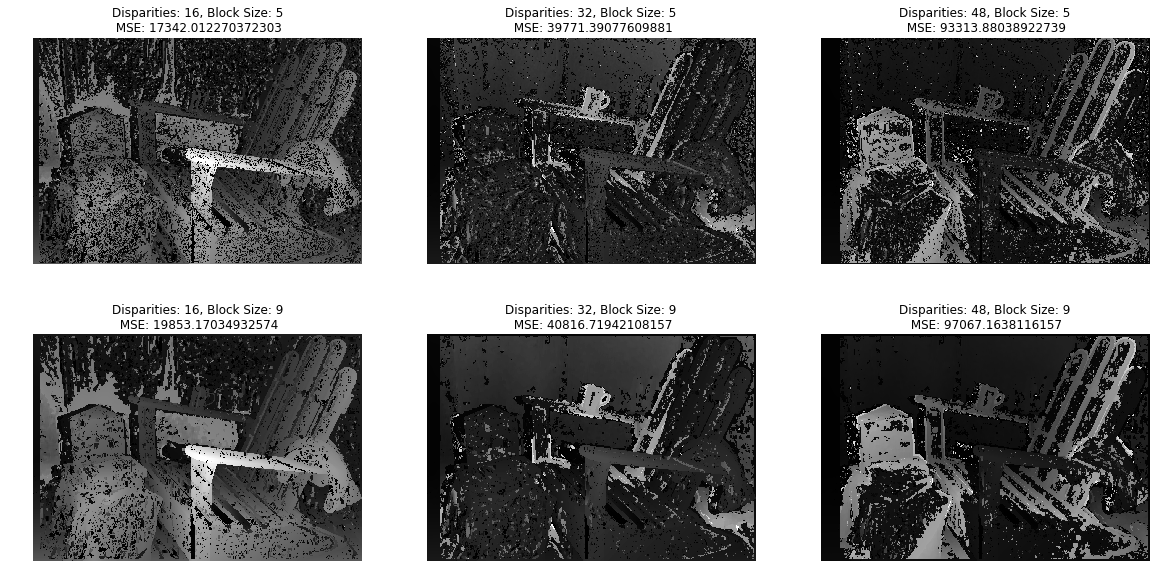

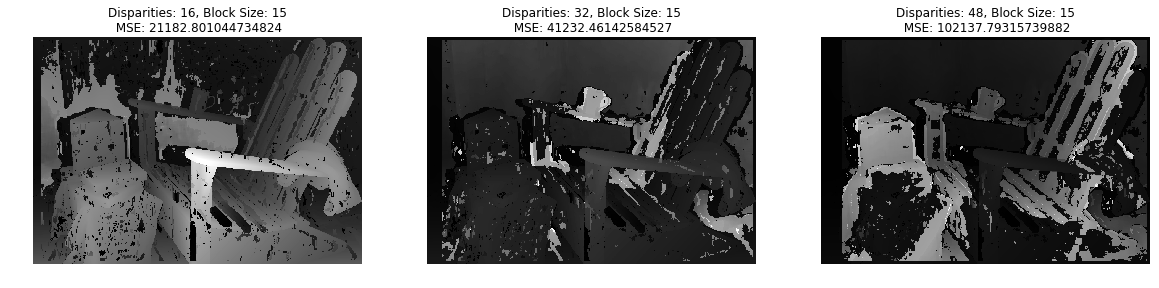

In [13]:
# compute pixel-wise squared difference error
for i in range(len(results)):
    mse, error_map = compute_mse(ground_truth, results[i]['depth_map'])
    # update results dictionary
    results[i]['error_map'] = error_map 
    results[i]['mse'] = mse
    results[i]['title'] = 'Disparities: ' + str(results[i]['num_disparities']) + ', Block Size: ' + str(results[i]['block_size']) + '\n MSE: ' + str(mse) 

print('Error maps for each permutation with higher errors having brighter pixels')

# plot with depth maps
plot_figs(results,'error_map', 3)

#### Comment on the error-maps for each combination of parameters. Specifically, mention the eﬀects of varying the parameters on the error in the region of high/low texture, edge, large/small depths.

When the number of disparities and block sizes are lower, the overall mean squared error is lower. While each individual error is small, this comes with the tradeoff of having a higher quantity of errors - few pixels match the actual ground truth.

On the other hand, when the number of disparities and block sizes are higher, the overall mean squared error is higher. While the errors that occur are extremely high, there is the benefit that many regions have little to no error from its ground truth - pixels are either very far or very close to the ground truth.

The error for low texture regions decreases when the block size is increased, while the error for high texture regions increase with increasing block size. The error for small depth regions decreases as the number of disparities increase, while the error for large depth regions increases as the number of dispartieis in decrease.